I will be solving the problem shown using the [Nutils](http://www.nutils.org/en/latest/) Finite Element programming library.

The strong form of the equation is 
$$ - \nabla\cdot\left( D \nabla \phi_0\right) \,+\, \Sigma_a\, \phi_0 = Q_0 $$ where $D = \frac{1}{3\Sigma_t}\,$ and $\,\Sigma_a = \Sigma_t - \Sigma_s^0$

To solve the problem using the Galerkin method, we work with the weak form given by: $$ \int_{\Omega}D \,\nabla N_A \,\cdot\,\nabla \phi_0 \, dx - \int_{\partial \Omega}N_A D\nabla \phi_0 \cdot\hat{n} \, ds  + \int_{\Omega} N_A \, \Sigma_a \phi_0\,dx = \int_{\Omega} N_A\, Q_0 \, dx $$ 

where $N_A$ is a basis function over the mesh and $\phi_0 = \sum_A c_A N_A$. For this problem, we use either vacuum boundary condition ($\phi_0 = 0$ on $\partial \Omega$) or reflecting boundary condition ($\hat{n} \cdot \nabla \phi_0 = 0$). In both cases, the Galerkin weak form simplifies to 

$$ \int_{\Omega}D \,\nabla N_A \,\cdot\,\nabla \phi_0 \, dx  + \int_{\Omega} N_A \, \Sigma_a \phi_0\,dx = \int_{\Omega} N_A\, Q_0 \, dx $$ 

This is the weak form we will use in the code below


optimize > constrained 100/676 dofs
optimize > optimum value 0.00e+00
solve > solving 576 dof system to machine precision using arnoldi solver
solve > solver returned with residual 8e-16


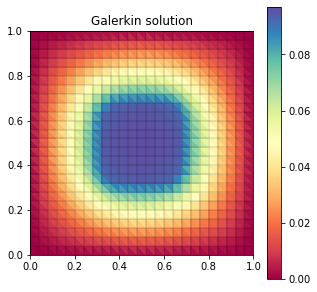

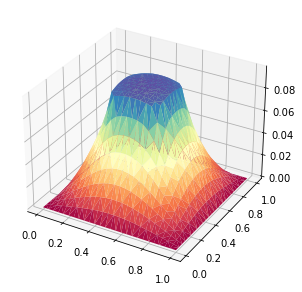

In [3]:
from nutils import function, mesh, solver
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import collections
from mpl_toolkits.mplot3d import Axes3D

degree = 1 #degree of basis functions
nelems = 25 #number of elements along edge of unit square
W = 1 #width of outer box
Wi = .3 #width of inner box

mat_flag = 'scatterer' #TYPE OF MATERIAL IN OUTER BOX. OTHER POSSIBILITIES: 'reflector' 'absorber' 'air'
if mat_flag == 'scatterer':
    sigt = 2
    sigs = 1.99
elif mat_flag == 'reflector':
    sigt = 2
    sigs = 1.8
elif mat_flag == 'absorber':
    sigt = 10
    sigs = 2
elif mat_flag == 'air':
    sigt = .01
    sigs = .006
    
BC_flag = 'vacuum' #TYPE OF BOUNDARY CONDITION. OPTIONS ARE: 'vacuum' 'reflecting'
    
topo, geom = mesh.unitsquare(nelems, 'square') #unit square centred at (0.5, 0.5)
ns = function.Namespace()
ns.basis = topo.basis('lagrange', degree = degree)

ns.W = W
#ns.Wi = Wi

ns.x = W * geom #scales the unit square to our physical square
ns.f =function.max(function.abs(ns.x[0] -  W/2), function.abs(ns.x[1] - W/2)) #level set function for inner square 
# 'max( abs(x_0 - W / 2), abs( x_1 - W / 2) )' 
inner, outer = function.partition(ns.f, Wi / 2) #indicator function for inner square and outer square

ns.phi = 'basis_A ?dofs_A'
ns.SIGs  = sigs * outer              #scattering cross-section
ns.SIGt  = 0.1 * inner + sigt* outer              #total cross-section
ns.SIGa = 'SIGt - SIGs' #absorption cross-section
ns.D = '1 / (3 SIGt)'   #diffusion co-efficient
ns.Q =  inner  #source term

if BC_flag == 'vacuum':
    sqr = topo.boundary.integral('(phi - 0)^2 J(x)' @ns, degree = degree * 2)
    cons = solver.optimize('dofs', sqr, droptol=1e-14) #this applies the boundary condition to u
    
    #residual
    res = topo.integral( '(D basis_i,j phi_,j + SIGa basis_i phi - basis_i Q) J(x)' @ ns, degree = degree * 2) 
    
    #solve for degrees of freedom
    dofs = solver.solve_linear('dofs', res, constrain = cons)
    
elif BC_flag == 'reflecting':
    #residual
    res = topo.integral( '(D basis_i,j phi_,j + SIGa basis_i phi - basis_i Q) J(x)' @ ns, degree = degree * 2) 
    
    #solve for degrees of freedom
    dofs = solver.solve_linear('dofs', res)
    
    
bezier = topo.sample('bezier', 2)
x = bezier.eval('x_i' @ ns)
phi = bezier.eval('phi' @ ns, dofs = dofs)

#ntl.export.triplot('ADSM_Gal.png', x, u, tri=bezier.tri, hull=bezier.hull)
fig = plt.figure(figsize = (5,5))
ax = fig.add_subplot(111, aspect= 'equal')
im = ax.tripcolor(x[:,0], x[:, 1], bezier.tri, phi, cmap = plt.cm.Spectral)
fig.colorbar(im)
ax.autoscale(enable= True, axis = 'both', tight = 'True')
ax.set_title('Galerkin solution')
ax.add_collection(collections.LineCollection(x[bezier.hull], colors='k', linewidths= .1))
plt.axis('on')

fig2 = plt.figure(figsize= (5,5))
ax2 = fig2.add_subplot(111, projection ='3d')
ax2.plot_trisurf( x[:, 0], x[:,1], phi, cmap=plt.cm.Spectral)
    
#print(lhs)